In [ ]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn scikit-learn opencv-python
%matplotlib inline

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import seaborn as sns
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
dataset_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/annotations'
image_files = sorted([f for f in os.listdir(dataset_pth) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])
xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])
%store -r df


In [1]:
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture
%run imageRead.ipynb

In [4]:
def parse_xml_annotation(xml_path):
    """Parse XML file and extract annotations"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Get image info
        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        # Extract objects
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            bbox = {
                'xmin': int(bndbox.find('xmin').text),
                'ymin': int(bndbox.find('ymin').text),
                'xmax': int(bndbox.find('xmax').text),
                'ymax': int(bndbox.find('ymax').text)
            }
            objects.append({'class': name, 'bbox': bbox})

        return {
            'filename': filename,
            'width': width,
            'height': height,
            'objects': objects
        }
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None

dataset_info = []

xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])
if len(xml_files) == 0:
    print(f"Warning: No XML files found in {annotations_pth}")

for xml_file in xml_files:
    xml_path = os.path.join(annotations_pth, xml_file)
    annotation = parse_xml_annotation(xml_path)

    if annotation:
        dataset_info.append({
            'image_name': annotation['filename'],
            'image_path': os.path.join(dataset_pth, annotation['filename']),
            'xml_path': xml_path,
            'width': annotation['width'],
            'height': annotation['height'],
            'num_objects': len(annotation['objects']),
            'objects': annotation['objects']
        })

df = pd.DataFrame(dataset_info)
%store df

print(f"Created DataFrame with {len(df)} samples")
df.head()
df.tail()

Stored 'df' (DataFrame)
Created DataFrame with 3231 samples


,image_name,image_path,xml_path,width,height,num_objects,objects
3226,\t230.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,784,334,2,"[{'class': 'Normal Flow', 'bbox': {'xmin': 101..."
3227,\t231.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,784,330,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3228,\t232.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,781,330,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3229,\t233.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,788,326,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3230,\t234.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,780,328,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."


In [5]:
#Ensure df is loaded
print("DataFrame loaded with", len(df), "rows")

DataFrame loaded with 3231 rows


In [6]:
df['image_name'] = df['image_name'].astype(str)
df['image_name'] = df['image_name'].str.replace('\t', '', regex=False)
df['image_name'] = df['image_name'].str.strip()

df['image_path'] = df['image_name'].apply(lambda x: os.path.join(dataset_pth, x))

print("Sample image names and paths:")
print(df[['image_name', 'image_path']].head())

# Find annotations with missing image files
missing = df[~df['image_path'].apply(os.path.exists)]
print("Number of missing image files:", len(missing))

if len(missing) > 0:
    print("Example of missing files:")
    print(missing[['image_name', 'image_path']].head())

df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print("After removing missing images, total rows:", len(df))

missing_after = df[~df['image_path'].apply(os.path.exists)]
print("After cleaning, missing files:", len(missing_after))

Sample image names and paths:
   image_name                                         image_path
0  000000.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
1  000001.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2  000002.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
3  000003.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
4  000004.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
Number of missing image files: 316
Example of missing files:
     image_name                                         image_path
2915    136.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2916    145.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2917    235.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2918    236.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2919    237.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
After removing missing images, total rows: 2915
After cleaning, missing files: 0


In [7]:
class DenoiseTransform:
    """
    Apply gentle, edge-preserving denoising using OpenCV fastNlMeansDenoisingColored.
    Input : PIL Image (RGB)
    Output: PIL Image (RGB) after noise reduction
    """
    def __call__(self, img_pil):
        # Convert PIL -> NumPy (RGB)
        img_np = np.array(img_pil)

        # OpenCV expects BGR, so convert if needed
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Apply gentle denoising (small h values to avoid over-smoothing)
        denoised_bgr = cv2.fastNlMeansDenoisingColored(
            img_bgr,
            None,
            h=6,          # luminance filter strength
            hColor=6,     # color filter strength
            templateWindowSize=7,
            searchWindowSize=21
        )

        # Back to RGB
        denoised_rgb = cv2.cvtColor(denoised_bgr, cv2.COLOR_BGR2RGB)

        # Convert back to PIL
        return Image.fromarray(denoised_rgb)

Image: 000000.jpg


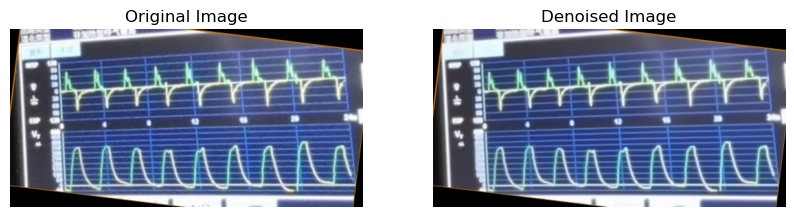

Image: 000001.jpg


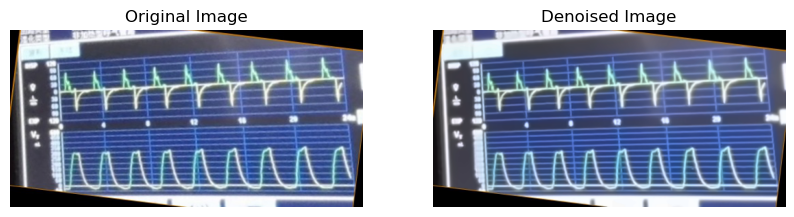

Image: 000002.jpg


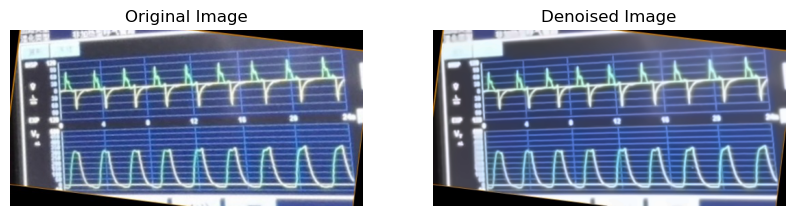

Image: 000003.jpg


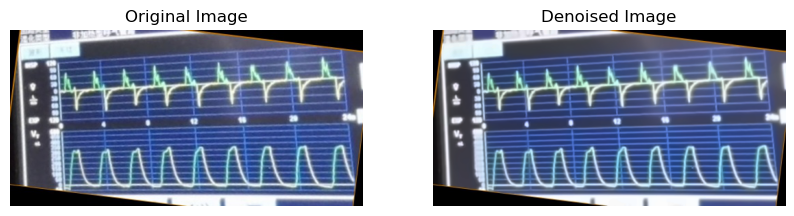

Image: 000004.jpg


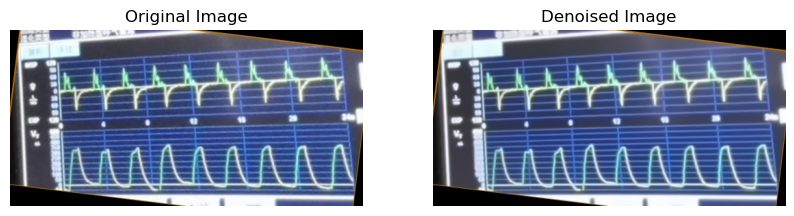

In [8]:
for image_file in image_files[:5]:
    img_path = os.path.join(dataset_pth, image_file)
    row = df[df['image_name'] == image_file].iloc[0]
    denoise_transform = DenoiseTransform()
    original_img = Image.open(img_path).convert('RGB')
    denoised_img = denoise_transform(original_img)


    print(f"Image: {row['image_name']}")
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Denoised Image")
    plt.imshow(denoised_img)
    plt.axis('off')
    plt.show()

In [9]:
print("=== NORMALIZATION PIXELS [0,1] ===")

for image_file in image_files[:2]:
    img_path = os.path.join(dataset_pth, image_file)
    image_pil = Image.open(img_path)
    image_array = np.array(image_pil)

    # normalization to [0,1]
    normalized = image_array.astype(np.float32) / 255.0
    print(f"{image_file}:")
    print(f"   Original range: [{image_array.min()}, {image_array.max()}]")
    print(f"   After /255:     [{normalized.min():.3f}, {normalized.max():.3f}]")
    print(f"   First pixel values:")
    print(f"   Original: {image_array[0,0,:]}")
    print(f"   After /255: {normalized[0,0,:]}")
    print()


=== NORMALIZATION PIXELS [0,1] ===
000000.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
   Original: [1 0 4]
   After /255: [0.00392157 0.         0.01568628]

000001.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
   Original: [1 0 4]
   After /255: [0.00392157 0.         0.01568628]



In [10]:
from collections import Counter


all_raw_labels = set()
for objs in df['objects']:
    for obj in objs:
        name = str(obj.get('class', '')).strip()
        if name:
            all_raw_labels.add(name)

CLASSES = sorted(all_raw_labels)
NUM_CLASSES = len(CLASSES)

label_to_idx = {lab: i for i, lab in enumerate(CLASSES)}
idx_to_label = {i: lab for lab, i in label_to_idx.items()}

print("Number of classes:", NUM_CLASSES)
print("Example classes:", CLASSES[:10])

def encode_label_id(row):
    names = [
        str(obj.get('class', '')).strip()
        for obj in row['objects']
        if str(obj.get('class', '')).strip()
    ]

    if not names:
        return -1

    counter = Counter(names)
    main_label, _ = counter.most_common(1)[0]
    return label_to_idx[main_label]

df['label_id'] = df.apply(encode_label_id, axis=1)

df = df[df['label_id'] >= 0].reset_index(drop=True)

df['label_name'] = df['label_id'].map(idx_to_label)

print("Total samples after fine labeling:", len(df))
print("Counts per class (by id):")
print(df['label_id'].value_counts().sort_index())

print(df[['image_name', 'label_id', 'label_name']].head(10))

Number of classes: 12
Example classes: ['Accumulation Flow', 'Double_Triggering Flow', 'Double_Triggering Volume', 'Flow', 'Ineffective_effort Flow', 'Ineffective_effort Volume', 'Leakage Volume', 'Normal Flow', 'Normal Volume', 'Premature_cycling Flow']
Total samples after fine labeling: 2915
Counts per class (by id):
label_id
0     554
1     405
2      18
3     341
4     424
5      14
6     111
7     532
8      32
9     434
10     42
11      8
Name: count, dtype: int64
   image_name  label_id         label_name
0  000000.jpg         0  Accumulation Flow
1  000001.jpg         0  Accumulation Flow
2  000002.jpg         0  Accumulation Flow
3  000003.jpg         0  Accumulation Flow
4  000004.jpg         0  Accumulation Flow
5  000005.jpg         0  Accumulation Flow
6  000006.jpg         0  Accumulation Flow
7  000007.jpg         0  Accumulation Flow
8  000008.jpg         0  Accumulation Flow
9  000009.jpg         0  Accumulation Flow


In [11]:
print("Number of classes:", NUM_CLASSES)
for i, name in enumerate(CLASSES):
    print(i, "→", name)

Number of classes: 12
0 → Accumulation Flow
1 → Double_Triggering Flow
2 → Double_Triggering Volume
3 → Flow
4 → Ineffective_effort Flow
5 → Ineffective_effort Volume
6 → Leakage Volume
7 → Normal Flow
8 → Normal Volume
9 → Premature_cycling Flow
10 → Premature_cycling Volume
11 → Volume


In [12]:
from sklearn.model_selection import train_test_split

print("Total samples after labeling:", len(df))

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=df['label_id']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=temp_df['label_id']
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train label counts:\n", train_df['label_id'].value_counts().sort_index())
print("Val label counts:\n",   val_df['label_id'].value_counts().sort_index())
print("Test label counts:\n",  test_df['label_id'].value_counts().sort_index())

Total samples after labeling: 2915
Train: 2040 Val: 437 Test: 438
Train label counts:
 label_id
0     388
1     283
2      12
3     239
4     297
5      10
6      78
7     372
8      22
9     304
10     29
11      6
Name: count, dtype: int64
Val label counts:
 label_id
0     83
1     61
2      3
3     51
4     63
5      2
6     16
7     80
8      5
9     65
10     7
11     1
Name: count, dtype: int64
Test label counts:
 label_id
0     83
1     61
2      3
3     51
4     64
5      2
6     17
7     80
8      5
9     65
10     6
11     1
Name: count, dtype: int64


In [13]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])


class TanafsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row['image_path']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_id = int(row['label_id'])
        label = torch.tensor(label_id, dtype=torch.long)

        return image, label

In [14]:
BATCH_SIZE = 16

train_dataset = TanafsDataset(train_df, transform=train_transform)
val_dataset   = TanafsDataset(val_df,   transform=val_test_transform)
test_dataset  = TanafsDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("First 5 labels:", labels[:5])

Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First 5 labels: tensor([4, 3, 9, 7, 1])


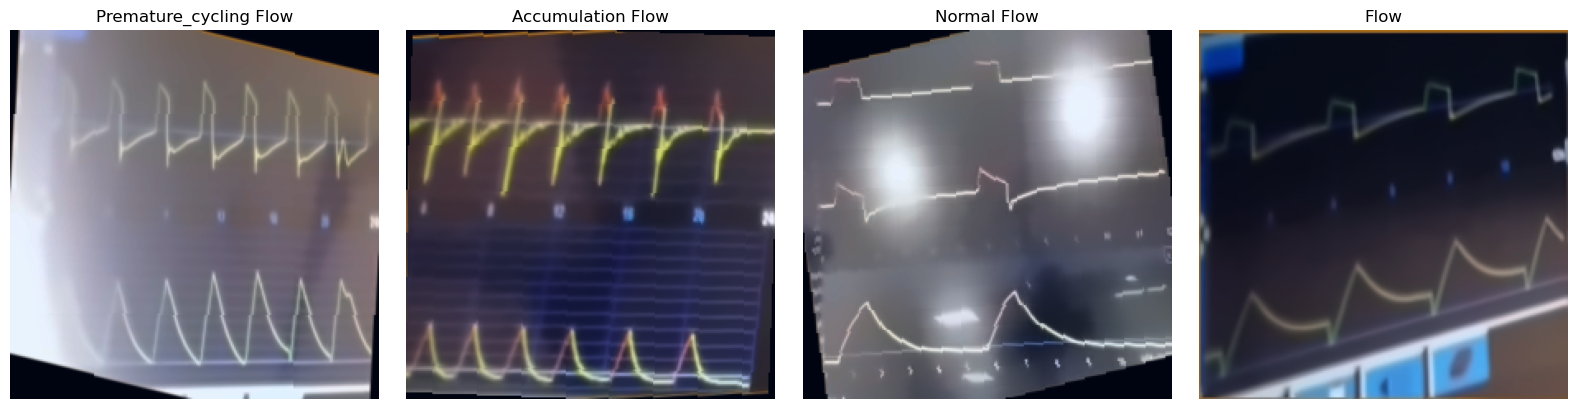

In [15]:
def show_batch(images, labels, classes, n=4):
    imgs = images[:n].clone().detach()
    imgs = imgs.permute(0, 2, 3, 1)  # [B,H,W,3]

    plt.figure(figsize=(4 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i].numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        ax.imshow(img)
        cls_id = int(labels[i].item())
        cls_name = classes[cls_id]
        ax.set_title(cls_name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, CLASSES, n=4)


# **ResNet training (CNN)**

1) Dataset Class

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class WaveformDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = int(row["label_id"])

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


 2) DataLoaders

In [17]:
BATCH_SIZE = 16

train_dataset = WaveformDataset(train_df, transform=train_transform)
val_dataset   = WaveformDataset(val_df,   transform=val_test_transform)
test_dataset  = WaveformDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("Loaders ready.")


Loaders ready.


3) Load ResNet18 pretrained

In [18]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(df['label_id'].unique())

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# تعديل آخر طبقة
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("Model loaded on:", device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Njood/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:05<00:00, 7.85MB/s]

Model loaded on: cpu


 4) Loss + Optimizer + Class Weights

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id']
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


5) Training Loop

In [20]:
EPOCHS = 15

best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # ===== Validation =====
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18.pth")
        print("Saved new BEST model!")

print("Training Complete.")


Epoch 1/15 | Train Loss: 1.1092, Train Acc: 0.6588 | Val Loss: 0.5228, Val Acc: 0.8284
Saved new BEST model!
Epoch 2/15 | Train Loss: 0.4524, Train Acc: 0.8657 | Val Loss: 0.3417, Val Acc: 0.8833
Saved new BEST model!
Epoch 3/15 | Train Loss: 0.3088, Train Acc: 0.9025 | Val Loss: 0.3165, Val Acc: 0.8810
Epoch 4/15 | Train Loss: 0.2458, Train Acc: 0.9181 | Val Loss: 0.2274, Val Acc: 0.9085
Saved new BEST model!
Epoch 5/15 | Train Loss: 0.1923, Train Acc: 0.9284 | Val Loss: 0.2424, Val Acc: 0.9291
Saved new BEST model!
Epoch 6/15 | Train Loss: 0.1912, Train Acc: 0.9353 | Val Loss: 0.2382, Val Acc: 0.9291
Epoch 7/15 | Train Loss: 0.1585, Train Acc: 0.9431 | Val Loss: 0.2679, Val Acc: 0.9336
Saved new BEST model!
Epoch 8/15 | Train Loss: 0.1258, Train Acc: 0.9583 | Val Loss: 0.2113, Val Acc: 0.9497
Saved new BEST model!
Epoch 9/15 | Train Loss: 0.0881, Train Acc: 0.9691 | Val Loss: 0.2349, Val Acc: 0.9405
Epoch 10/15 | Train Loss: 0.0693, Train Acc: 0.9750 | Val Loss: 0.2020, Val Acc: 0.95

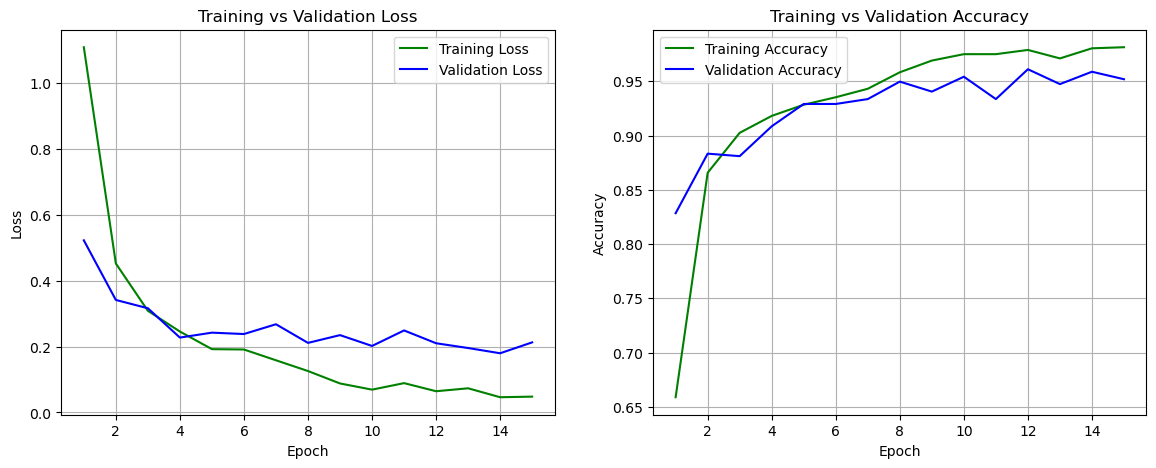

In [21]:
train_losses = [
    1.1092, 0.4524, 0.3088, 0.2458, 0.1923,
    0.1912, 0.1585, 0.1258, 0.0881, 0.0693,
    0.0891, 0.0645, 0.0734, 0.0463, 0.0481
]
val_losses = [
    0.5228, 0.3417, 0.3165, 0.2274, 0.2424,
    0.2382, 0.2679, 0.2113, 0.2349, 0.2020,
    0.2491, 0.2102, 0.1957, 0.1798, 0.2129
]
train_accuracies = [
    0.6588, 0.8657, 0.9025, 0.9181, 0.9284,
    0.9353, 0.9431, 0.9583, 0.9691, 0.9750,
    0.9750, 0.9789, 0.9711, 0.9804, 0.9814
]
val_accuracies = [
    0.8284, 0.8833, 0.8810, 0.9085, 0.9291,
    0.9291, 0.9336, 0.9497, 0.9405, 0.9542,
    0.9336, 0.9611, 0.9474, 0.9588, 0.9519
]
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='green')
plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


6) Evaluation on Test Set (Accuracy + F1 + Confusion Matrix)

In [24]:
import torch
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# تحميل أفضل أوزان للموديل
best_model = model  # نستخدم نفس الموديل اللي دربناه
state_dict = torch.load("best_resnet18.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

# تقييم على test_loader باستخدام نفس evaluate اللي عندك
test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2581
Test Accuracy: 0.9589



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        83
           1       0.97      0.95      0.96        61
           2       1.00      0.67      0.80         3
           3       0.98      0.98      0.98        51
           4       0.98      0.97      0.98        64
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00        17
           7       0.99      0.95      0.97        80
           8       0.62      1.00      0.77         5
           9       0.95      0.92      0.94        65
          10       1.00      1.00      1.00         6
          11       0.50      1.00      0.67         1

    accuracy                           0.96       438
   macro avg       0.91      0.95      0.92       438
weighted avg       0.96      0.96      0.96       438



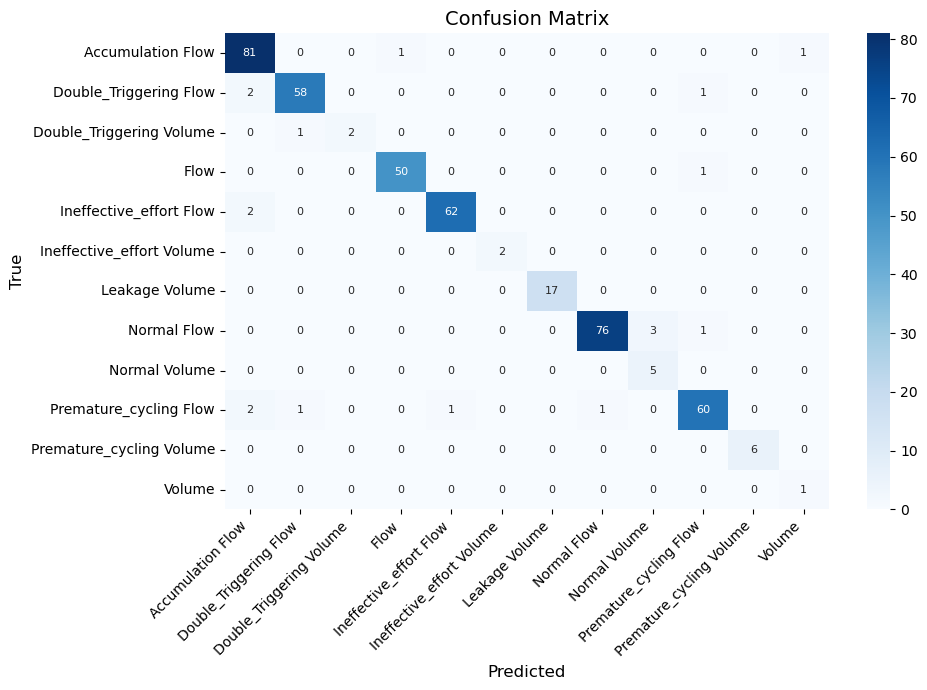

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_resnet18.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(
    cm,
    annot=True,        
    fmt="d",           
    cmap="Blues",     
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    annot_kws={"size": 8}  
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571

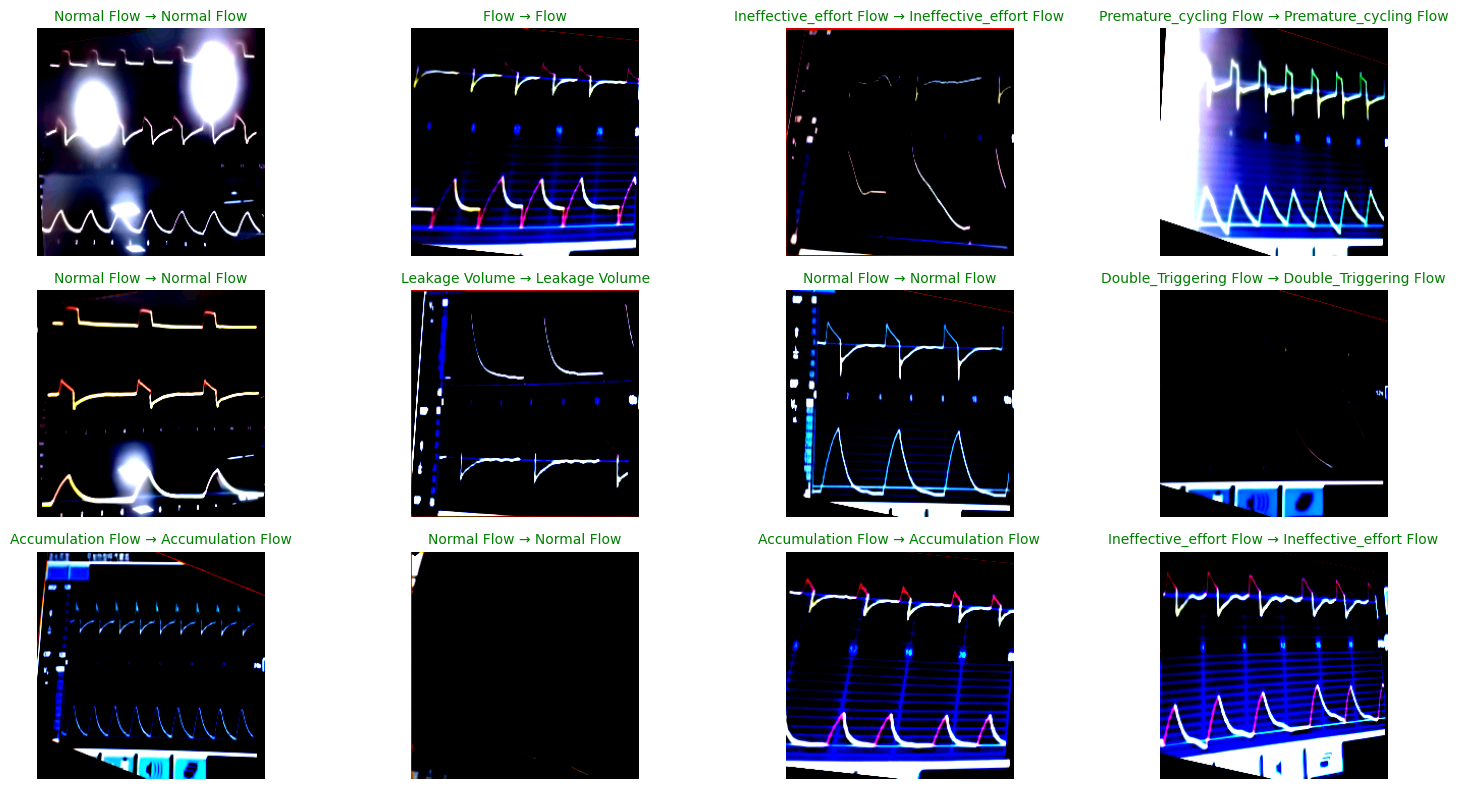

In [29]:
# %%
def show_predictions_grid(model, loader, class_names, device, num_images=12):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                img = images[i].cpu().permute(1, 2, 0).numpy()
                # لو فيه Normalization ممكن تحتاجين ترجعينه [0,1] أو [0,255] حسب البريبروسيس

                label = labels[i].item()
                pred = preds[i].item()

                true_name = class_names[label]
                pred_name = class_names[pred]

                ax = plt.subplot(3, 4, images_shown + 1)
                ax.imshow(img)
                ax.axis("off")

                title = f"{true_name} → {pred_name}"
                color = "green" if label == pred else "red"
                ax.set_title(title, color=color, fontsize=10)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

show_predictions_grid(best_model, test_loader, CLASSES, device, num_images=12)
